In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore, randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import export_graphviz
import graphviz

# decision trees can handle data with little to no preprocessing
# inspiration: https://www.datacamp.com/tutorial/random-forests-classifier-python
# onehot encoding for categorical data: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
# example:  https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
# maybe use: https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier to get better results

In [2]:
# load data and set options
df = pd.read_csv('data/AIDS_Classification.csv') #  , dtype={'hemo': 'category', 'homo': 'category', 'drugs': 'category', 'trt': 'category', 'oprior': 'category', 'z30': 'category', 'gender': 'category', 'str2': 'category', 'strat': 'category', 'symptom': 'category', 'treat': 'category', 'offtrt': 'category', 'infected': 'category'})


# drop race column -> us dataset 
# df = df.drop(columns='race')

pd.options.display.float_format = '{:.2f}'.format

In [3]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
zscores = df[numeric_cols].apply(zscore)
zscores.describe()

# we ll see if we need a special tretment for high values in cd*, other seems ok

,time,age,wtkg,karnof,preanti,race,cd40,cd420,cd80,cd820
count,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00
mean,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.96,-2.67,-3.33,-4.31,-0.81,-0.64,-2.96,-2.23,-1.97,-1.82
25%,-0.52,-0.72,-0.64,-0.92,-0.81,-0.64,-0.73,-0.71,-0.69,-0.68
50%,0.40,-0.14,-0.06,0.77,-0.51,-0.64,-0.09,-0.13,-0.20,-0.16
75%,0.73,0.55,0.56,0.77,0.77,1.57,0.61,0.61,0.46,0.47
max,1.20,3.99,6.40,0.77,5.28,1.57,7.16,5.17,8.38,11.46


In [4]:
df.describe(include='category')

,trt,hemo,homo,drugs,oprior,z30,gender,str2,strat,symptom,treat,offtrt,infected
count,2139,2139,2139,2139,2139,2139,2139,2139,2139,2139,2139,2139,2139
unique,4,2,2,2,2,2,2,2,3,2,2,2,2
top,3,0,1,0,0,1,1,1,1,0,1,0,0
freq,561,1959,1414,1858,2092,1177,1771,1253,886,1769,1607,1363,1618


In [5]:
# process a new dataframe
def preprocessing_category(df, col):
    # initalize encoder
    enc = OneHotEncoder(handle_unknown='ignore', feature_name_combiner='concat')

    # transform feature by using encoder    
    new_features_array = enc.fit_transform(df[[col]]).toarray()
    columns = enc.get_feature_names_out()

    # create new dataframe with new features
    enc_df = pd.DataFrame(new_features_array, columns=columns)
    
    # join new features to existing dataframe
    df = df.join(enc_df)
    # drop old feature column
    df = df.drop(columns=col)
    return df

# only preprocess columns with more than 2 values
df = preprocessing_category(df, 'trt')
df = preprocessing_category(df, 'strat')
df.describe()

,time,age,wtkg,karnof,preanti,race,cd40,cd420,cd80,cd820,trt_0,trt_1,trt_2,trt_3,strat_1,strat_2,strat_3
count,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00,2139.00
mean,879.10,35.25,75.13,95.45,379.18,0.29,350.50,371.31,986.63,935.37,0.25,0.24,0.24,0.26,0.41,0.19,0.39
std,292.27,8.71,13.26,5.90,468.66,0.45,118.57,144.63,480.20,444.98,0.43,0.43,0.43,0.44,0.49,0.39,0.49
min,14.00,12.00,31.00,70.00,0.00,0.00,0.00,49.00,40.00,124.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,727.00,29.00,66.68,90.00,0.00,0.00,263.50,269.00,654.00,631.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,997.00,34.00,74.39,100.00,142.00,0.00,340.00,353.00,893.00,865.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1091.00,40.00,82.56,100.00,739.50,1.00,423.00,460.00,1207.00,1146.50,0.00,0.00,0.00,1.00,1.00,0.00,1.00
max,1231.00,70.00,159.94,100.00,2851.00,1.00,1199.00,1119.00,5011.00,6035.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [6]:
# split data
X = df.drop(columns='infected')
y = df['infected']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(1711, 428, 1711, 428)

In [7]:
# https://www.google.com/search?q=youtube+random+forest+fr&rlz=1C5CHFA_enFR1046FR1046&oq=youtube+random+forest+fr&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIGCAEQRRhA0gEINDYwMWowajSoAgCwAgE&sourceid=chrome&ie=UTF-8#fpstate=ive&vld=cid:ff02d371,vid:QQN5NjJtUcc,st:0
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [8]:
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='1')
recall = recall_score(y_test, y_pred, pos_label='1')

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("Accuracy:", accuracy)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
print("Precision:", precision)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
print("Recall:", recall)

Accuracy: 0.8785046728971962
Precision: 0.8356164383561644
Recall: 0.6039603960396039


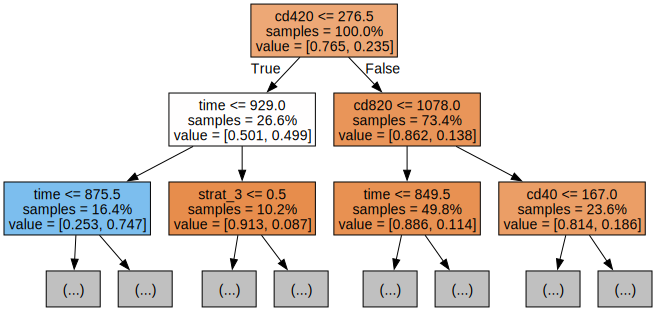

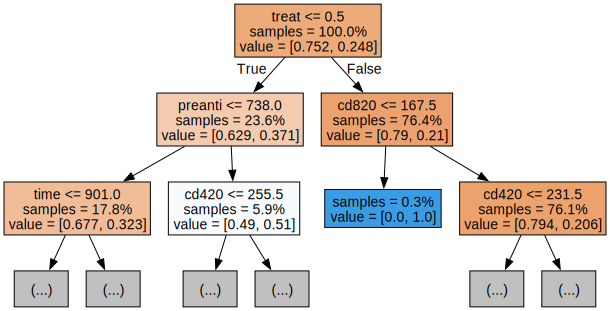

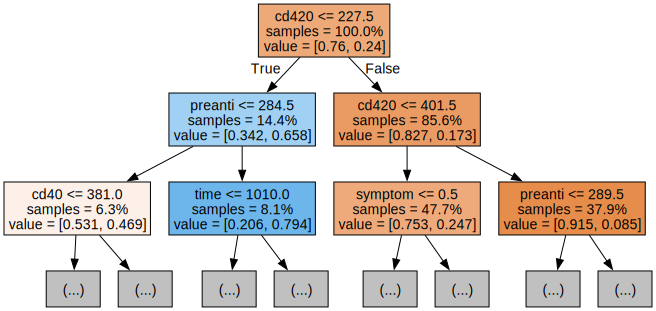

In [9]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [10]:
param_dist = {
    'n_estimators': randint(50, 1000),
    'max_depth': randint(1, 50),
}

print(param_dist)
rf2 = RandomForestClassifier(class_weight='balanced')

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=30,
                                 cv=5)

rand_search.fit(X_train, y_train)

{'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3024cd450>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3024b0d10>}


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3024b0d10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3024cd450>})

In [11]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)



Best hyperparameters: {'max_depth': 31, 'n_estimators': 620}


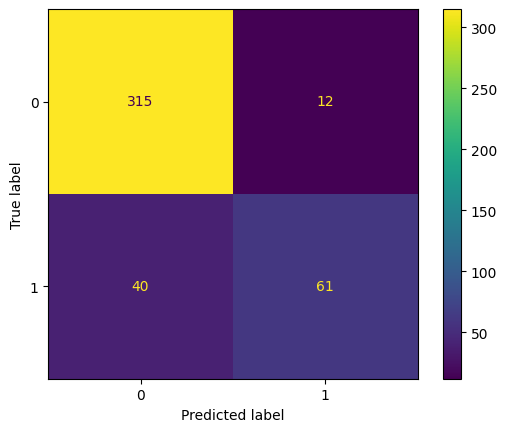

In [12]:
# Generate predictions with the best model
y_pred = rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [13]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='1')
recall = recall_score(y_test, y_pred, pos_label='1')

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("Accuracy:", accuracy)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
print("Precision:", precision)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
print("Recall:", recall)

Accuracy: 0.8808411214953271
Precision: 0.8378378378378378
Recall: 0.6138613861386139


<Axes: >

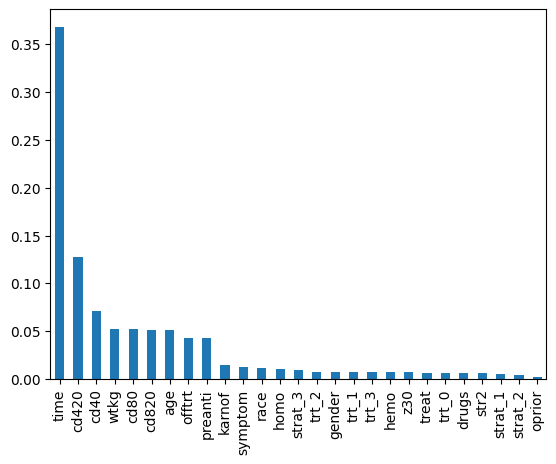

In [14]:
# Create a series containing feature importances from the model and feature names from the training data
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()